# Non-IC Measurements

This document shows you how to use measurements that are not informationally complete.

> **Note**:
>
> By definition, non-IC POVMs do not span the entire space of Hermitian operators. This means that
> there exist some observables that are not covered by such POVMs. At present, the post-processor
> does not check for this when estimating expectation values. This means it is up to the user to
> ensure that they submits observables compatible with the non-IC POVM.
>
>
> If the user submits an observable that is not in the span of the POVM, the post-processor will
> return the expectation value of the observable projected into the span of the POVM. More
> specifically, this will not give rise to any errors and may go unnoticed by the user.

In [1]:
%load_ext autoreload
%autoreload 2

## Examples of non-IC POVMs

### Example of a 4-outcome non-IC POVM

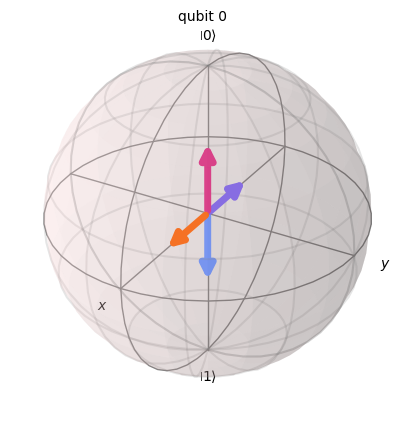

In [2]:
import numpy as np
from povm_toolbox.library import RandomizedProjectiveMeasurements

# parameters that define a randomized measurement which is not IC. It mixes `Z` and `X` measurements.
angles = np.array(
    [0.0, 0.0, np.pi / 2, 0.0],
)
bias = np.array([0.5, 0.5])

ZX_measurement = RandomizedProjectiveMeasurements(
    num_qubits=1, angles=angles, bias=bias, seed=592634
)
ZX_measurement.definition().draw_bloch()

### Example of a POVM with some null effects
Some POVMs that are usually informationally complete can become non-IC in special cases.

For instance, setting some biases to zero for a randomized measurement will result into some effects being null. This can make the POVM non-IC.
The null effects are still being stored, which can prove useful if you follow a convention for the indexing of the outcomes (see the example below).

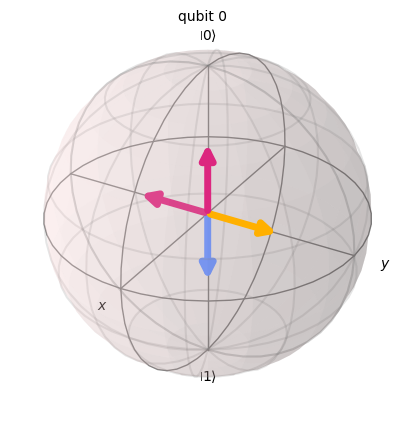

In [3]:
import numpy as np
from povm_toolbox.library import LocallyBiasedClassicalShadows

# Define a biased classical shadow measurement with only `Z` and `Y` measurements.
bias = np.array([0.5, 0.0, 0.5])  # order is Z,X,Y

ZY_measurement = LocallyBiasedClassicalShadows(num_qubits=1, bias=bias, seed=587202)
ZY_measurement.definition().draw_bloch()

We assume in general that a (locally-biased) classical shadow measurement has 6 outcomes. Therefore, even if we set the bias of a measurement basis to zero, we keep track of the resulting null effects to preserve the number of outcomes and their order.

In [4]:
povm = ZY_measurement.definition()[(0,)]
print("Number of outcomes:", povm.num_outcomes)
print("\nPOVM effects:")
for op in povm.operators:
    print(op)

Number of outcomes: 6

POVM effects:
Operator([[0.5+0.j, 0. +0.j],
          [0. +0.j, 0. +0.j]],
         input_dims=(2,), output_dims=(2,))
Operator([[0. +0.j, 0. +0.j],
          [0. -0.j, 0.5+0.j]],
         input_dims=(2,), output_dims=(2,))
Operator([[0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))
Operator([[0.+0.j, 0.+0.j],
          [0.-0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))
Operator([[2.5000000e-01+0.j  , 1.5308085e-17-0.25j],
          [1.5308085e-17+0.25j, 2.5000000e-01+0.j  ]],
         input_dims=(2,), output_dims=(2,))
Operator([[ 2.5000000e-01+0.j  , -1.5308085e-17+0.25j],
          [-1.5308085e-17-0.25j,  2.5000000e-01+0.j  ]],
         input_dims=(2,), output_dims=(2,))


### Standard IC-POVM
For reference, we also consider a standard classical shadows measurement:

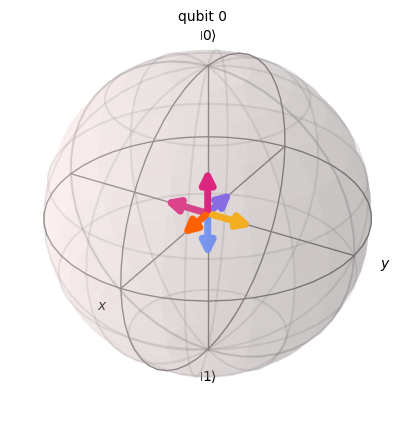

In [5]:
import numpy as np
from povm_toolbox.library import ClassicalShadows

ZXY_measurement = ClassicalShadows(num_qubits=1, seed=301438)
ZXY_measurement.definition().draw_bloch()

## Run experiments 
### Define quantum circuit

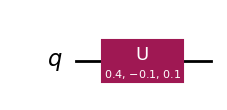

In [6]:
from qiskit.circuit import QuantumCircuit

qc = QuantumCircuit(1)
qc.u(0.4, -0.1, 0.1, qubit=0)
qc.draw("mpl")

### Run the job

In [7]:
from numpy.random import default_rng
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler(seed=default_rng(734567))
povm_sampler = POVMSampler(sampler)
job = povm_sampler.run(
    [
        (qc, None, None, ZXY_measurement),
        (qc, None, None, ZX_measurement),
        (qc, None, None, ZY_measurement),
    ],
    shots=4096,
)

### Define observable

Note that this observable is not fully covered by the `ZY_measurement`.

In [8]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["X", "Z"], coeffs=[3, 1])

### Get the expected value

In [9]:
from povm_toolbox.post_processor import POVMPostProcessor, dual_from_empirical_frequencies
from qiskit.quantum_info import DensityMatrix

print("Observable: Z + 3*X")

exact_expectation_value = np.real_if_close(DensityMatrix(qc).expectation_value(observable))
print(f"Exact value: {exact_expectation_value}\n")

print("Measurement          Estimated value   Estimated std   Actual error")
print("-------------------------------------------------------------------")

results = job.result()
msmt_strings = [
    "Classical shadows",
    "Z/X measurement",
    "Z/Y measurement",
]

for msmt, pub_result in zip(msmt_strings, results):
    post_processor = POVMPostProcessor(pub_result)
    post_processor.dual = dual_from_empirical_frequencies(post_processor)
    exp_value, std = post_processor.get_expectation_value(observable)
    print(
        f"{msmt:<17} {exp_value:>18.6f} {std:>15.6f}"
        f"{abs(exp_value - exact_expectation_value):>15.6f}"
    )

Observable: Z + 3*X
Exact value: 2.083479611901199

Measurement          Estimated value   Estimated std   Actual error
-------------------------------------------------------------------
Classical shadows           2.168970        0.076433       0.085491
Z/X measurement             2.064918        0.062295       0.018562
Z/Y measurement             0.925842        0.008414       1.157638


As the observable is not in the span `ZY_measurement`, it returns an incorrect value (without
warning). 

To be more specific, the observable $\mathcal{O} = Z+3*X$ projected into the span of
`ZY_measurement` is $\hat{\mathcal{O}} = Z$. Therefore, the value returned is the expectation of
$\hat{\mathcal{O}}$.

We can check the value returned by `ZY_measurement` is actually an estimate of $\langle Z \rangle_{\rho}$.

In [10]:
from povm_toolbox.post_processor import POVMPostProcessor, dual_from_empirical_frequencies
from qiskit.quantum_info import DensityMatrix

observable = SparsePauliOp("Z")
print("Observable: Z")

exact_expectation_value = np.real_if_close(DensityMatrix(qc).expectation_value(observable))
print(f"Exact value: {exact_expectation_value}\n")

print("Measurement          Estimated value   Estimated std   Actual error")
print("-------------------------------------------------------------------")

for msmt, pub_result in zip(msmt_strings, results):
    post_processor = POVMPostProcessor(pub_result)
    post_processor.dual = dual_from_empirical_frequencies(post_processor)
    exp_value, std = post_processor.get_expectation_value(observable)
    print(
        f"{msmt:<17} {exp_value:>18.6f} {std:>15.6f}"
        f"{abs(exp_value - exact_expectation_value):>15.6f}"
    )

Observable: Z
Exact value: 0.9210609940028851

Measurement          Estimated value   Estimated std   Actual error
-------------------------------------------------------------------
Classical shadows           0.914818        0.010650       0.006243
Z/X measurement             0.920608        0.008564       0.000453
Z/Y measurement             0.925842        0.008414       0.004781
